# Unsupervised Learning

Anomaly Detection

In [28]:
#Mount the google drive connection to our dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [29]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/AI/datasets/cpu4.csv')

In [30]:
df.head()

,timestamp,value,label
0,1469376000,0.847300,0
1,1469376300,-0.036137,0
2,1469376600,0.074292,0
3,1469376900,0.074292,0
4,1469377200,-0.036137,0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17568 entries, 0 to 17567
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  17568 non-null  int64  
 1   value      17568 non-null  float64
 2   label      17568 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 411.9 KB


In [32]:
df.describe()

,timestamp,value,label
count,1.756800e+04,1.756800e+04,17568.000000
mean,1.472011e+09,-1.963793e-11,0.011897
std,1.521477e+06,1.000028e+00,0.108424
min,1.469376e+09,-1.692583e+00,0.000000
25%,1.470694e+09,-9.195749e-01,0.000000
50%,1.472011e+09,-3.613731e-02,0.000000
75%,1.473329e+09,7.368706e-01,0.000000
max,1.474646e+09,3.939332e+00,1.000000


In [33]:
df.isnull().sum()

timestamp    0
value        0
label        0
dtype: int64

In [34]:
df.isna().sum()

timestamp    0
value        0
label        0
dtype: int64

Visualize the data

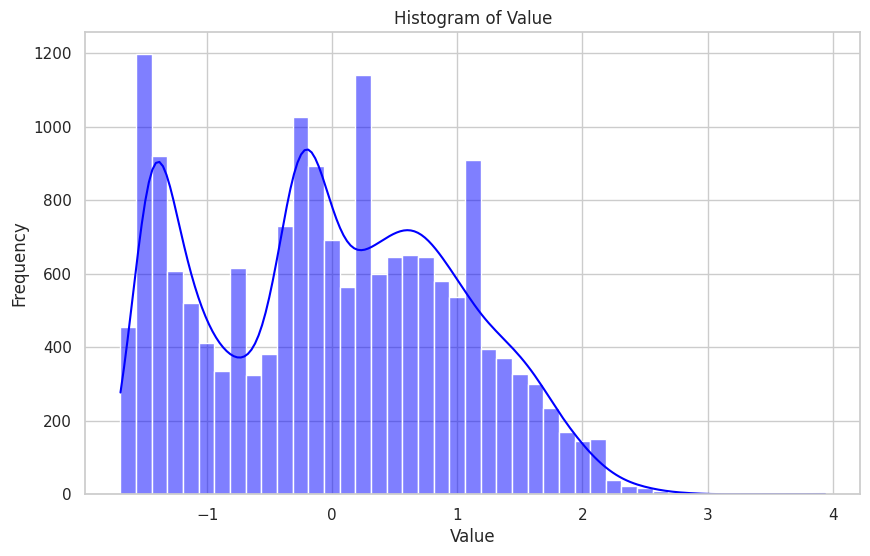

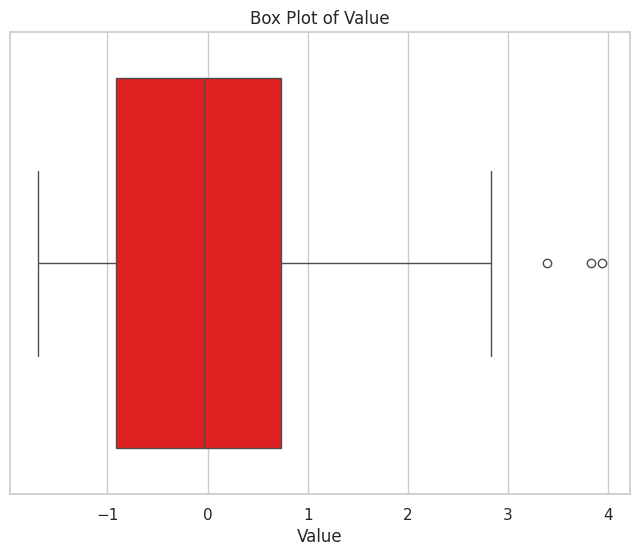

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df['value'], kde=True, color='blue')
plt.title('Histogram of Value')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=df['value'], color='red')
plt.title('Box Plot of Value')
plt.xlabel('Value')
plt.show()

<Axes: xlabel='timestamp'>

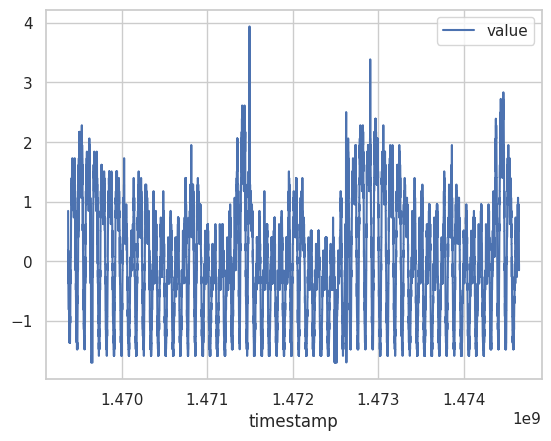

In [36]:
df.plot(x='timestamp', y='value')

Feature Engineering (Recovered from: https://www.kaggle.com/code/victorambonati/unsupervised-anomaly-detection)

In [37]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [38]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

outliers_fraction = 0.01

df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

<ipython-input-39-ac7007014465>:16: RuntimeWarning: divide by zero encountered in divide
  ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
<ipython-input-39-ac7007014465>:16: RuntimeWarning: invalid value encountered in divide
  ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
<ipython-input-39-ac7007014465>:17: RuntimeWarning: divide by zero encountered in divide
  ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
<ipython-input-39-ac7007014465>:17: RuntimeWarning: invalid value encountered in divide
  ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
<ipython-input-39-ac7007014465>:19: RuntimeWarning: divide by zero encountered in divide
  ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')
<ipython-input-39-ac70070

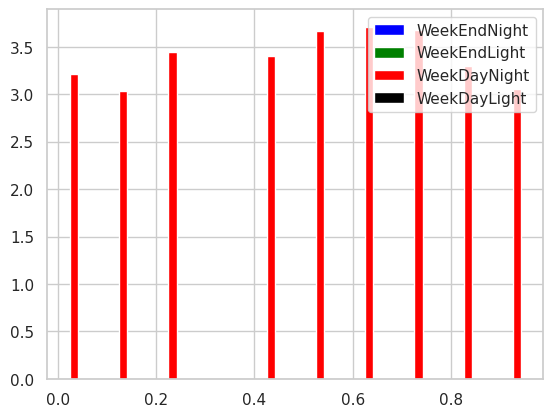

In [39]:
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

# One-class SVM

In [40]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [41]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

In [42]:
model =  OneClassSVM(nu=0.95 * outliers_fraction)
data = pd.DataFrame(np_scaled)
model.fit(data)

OneClassSVM(nu=0.0095)

In [43]:
df['anomaly_detection'] = pd.Series(model.predict(data))
df['anomaly_detection'] = df['anomaly_detection'].map( {1: 0, -1: 1} )
print(df['anomaly_detection'].value_counts())

0    15187
1     2381
Name: anomaly_detection, dtype: int64


Visualization of anomaly_detection throughout time

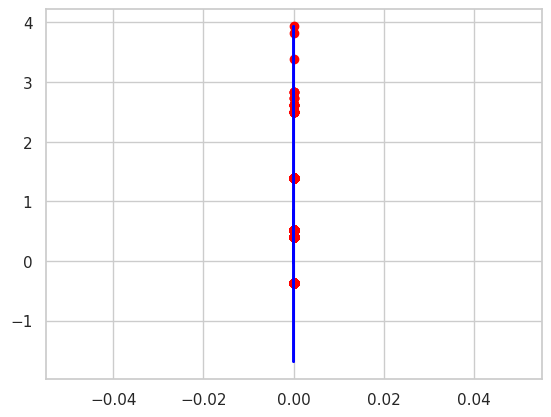

In [44]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly_detection'] == 1, ['time_epoch', 'value']]

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

# Visualization of anomaly in coherence with Benchmarking Values

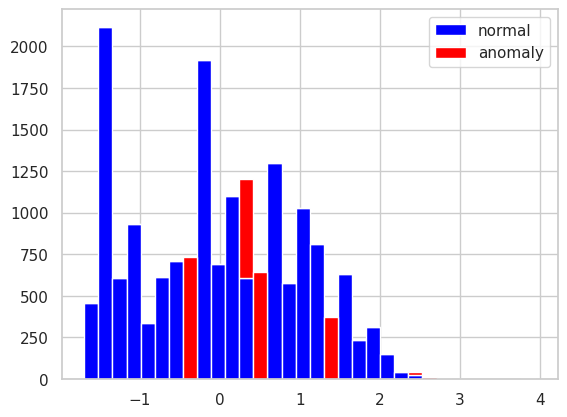

In [45]:
a = df.loc[df['anomaly_detection'] == 0, 'value']
b = df.loc[df['anomaly_detection'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()